<b>Español</b>

Este cuaderno está dedicado al estudio de la volatilidad en instrumentos financieros. Estos instrumentos financieros son aquellos cuyos subyacentes constituyen la base de otro instrumento financiero, como las opciones. Los subyacentes estudiados incluirán activos como criptomonedas (en este caso, Bitcoin), acciones (por ejemplo, acciones de índices como el NASDAQ, S&P 500 u otros), materias primas u otros tipos de activos.

En primer lugar, recopilaremos una cierta cantidad de datos sobre la actividad del activo financiero. Estos datos podrán ser en unidades de tiempo como horas, minutos, días o cualquier otra medida que se considere apropiada. Posteriormente, procederemos a analizar la distribución de la volatilidad observada, determinando si sigue una distribución específica (como normal, gamma, u otra) o si presenta características aleatorias. Una vez que se establezca el tipo de distribución, podremos calcular la probabilidad de que la volatilidad se sitúe dentro de uno u otro rango. Estos rangos se definirán como baja volatilidad, volatilidad media o alta volatilidad.

Además, analizaremos el clustering de la volatilidad, es decir, si periodos de baja volatilidad tienden a ser seguidos por otros de baja volatilidad, y lo mismo para periodos de alta volatilidad. Este análisis nos permitirá implementar modelos de predicción de volatilidad, como los modelos ARCH, GARCH u otros similares.

Estos modelos nos proporcionarán la capacidad de predecir la volatilidad implícita o la volatilidad futura del activo financiero en cuestión. Con los resultados obtenidos, los modelos se podrán aplicar principalmente en estrategias de valoración o en operaciones de compra y venta de opciones, aunque también pueden adaptarse a otras estrategias de mercado.

Un ejemplo de estas estrategias es el Butterfly Spread, que implica la compra y venta de opciones call. Este enfoque apuesta por la posibilidad de que, tras una disminución de la actividad, el precio del activo se mantenga dentro de un rango específico. Si el precio permanece dentro de ese rango, la estrategia será rentable. Por el contrario, si el precio se desvía significativamente del rango, la estrategia no generará beneficios.

Todas las explicaciones y comentarios del código estarán en inglés.

---

<b>English</b>

This notebook is dedicated to studying volatility in financial instruments. These financial instruments are those whose underlying assets form the basis of another financial instrument, such as options. The underlying assets analyzed will include cryptocurrencies (in this case, Bitcoin), stocks (e.g., shares from indices like NASDAQ, S&P 500, or others), commodities, or other types of assets.

First, we will gather a dataset on the financial activity of the asset. The data may be collected in time intervals such as hours, minutes, days, or any other preferred measure. Subsequently, we will analyze the distribution of the observed volatility to determine whether it follows a specific distribution (such as normal, gamma, or another) or if it exhibits random characteristics. Once the type of distribution is established, we can calculate the probability of volatility falling within certain ranges. These ranges will be classified as low volatility, medium volatility, or high volatility.

Additionally, we will examine volatility clustering, i.e., whether periods of low volatility tend to be followed by other low-volatility periods and whether high-volatility periods show similar patterns. This analysis will allow us to implement volatility prediction models, such as ARCH, GARCH, or similar frameworks.

These models will enable us to predict the implied volatility or future volatility of the financial asset being assessed. Once the volatility results are obtained, the models can be primarily applied in valuation strategies or in options trading, though they may also be adapted for other market strategies.

An example of these strategies is the Butterfly Spread, which involves buying and selling call options. This strategy assumes that, following a decrease in market activity, the asset price will remain within a specific range. If the price stays within this range, the strategy will be profitable. Conversely, if the price deviates significantly from the range, the strategy will not yield profits.

---

In [1]:
#Every important library we are gonna use (or not but is usefull to have as a resource)
import requests
import time
import datetime
import json
import websocket

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf 
from scipy.stats import shapiro, normaltest

The code will be in parts, usually there will be an explanation and examples of reasoning, then the working code.<br> I will diferenciate the explanation cells with #E and the working cells with #W

In [ ]:
#E
now = time.time() * 1000
start_date = datetime.datetime(2017, 8, 18) #It's the first available data from this source
startTime_0 = int(start_date.timestamp()*1000)

#As the API connection has a limit on how many requests per second, we are gonna divide dinamically the request into as few bunchs as possible.
time_diff = now - startTime_0
n_hours_diff = int(time_diff / (1000 * 60 * 60))

In [ ]:
#E
url = 'https://data-api.binance.vision/api/v3/klines'

#The limit is how many intervals per request, as we got 1000 in this API, we got n_requests.
symbol = 'BTCUSDT'
interval = '1h'
startTimes = [startTime_0]
limit = 1000

#Keep in mind the number of request will go up by one every 1000 hours (41 days and 16 hours).
n_requests = math.floor(n_hours_diff / limit)
pause_count = 0 #We'll count how many requests without a pause, and, if needed, pause the code for x seconds.
time_interval = 1000 * 60 * 60 * 1000 #Interval of 1000 hours, will be used to make multiple startTime_i

#This API has a weight of 2, and a limit of 1200, so we have 600 requests per minute.

In [ ]:
#E
data_example =[
                [
                    1499040000000,      #// Kline open time
                    "0.01634790",       #// Open price
                    "0.80000000",       #// High price
                    "0.01575800",       #// Low price
                    "0.01577100",       #// Close price
                    "148976.11427815",  #// Volume
                    1499644799999,      #// Kline Close time
                    "2434.19055334",    #// Quote asset volume
                    308,                #// Number of trades
                    "1756.87402397",    #// Taker buy base asset volume
                    "28.46694368",      #// Taker buy quote asset volume
                    "0"                 #// Unused field, ignore.
                  ]
                ]

From this data, we are interested in the first 6 values, from the open time to the volume (included), an will get a list for every one of them

In [ ]:
#E
Time, Open, High, Low, Close, Volume = [], [], [], [], [], []

response = requests.get(url, params = {'symbol' : symbol, 'interval' : interval, 'startTime' : startTime_0, 'limit' : limit})
initial_data = response.json()

In [ ]:
#E
print(initial_data[0][0],initial_data[-1][0])

In [ ]:
#E
hours_diff = initial_data[-1][0] - initial_data[0][0]

print(hours_diff, time_interval)

As we see, the diference between the first and last hour of data is the 3618000000, more than we have calculated before, and that is because we are getting 5 hours more of data by default, so we have to adjust to it. We adjust by adding the hours_dif and one hour to the startTime_{i-1}, because if we don't add that hour, the last and first hour of consecutive requests is gonna be the same hour.

In [ ]:
#E
startTime_1 = startTime_0 + hours_diff + 1000 * 60 * 60
response_1 = requests.get(url, params = {'symbol' : symbol, 'interval' : interval, 'startTime' : startTime_1, 'limit' : limit})
initial_data_1 = response_1.json()

print(initial_data_1[0][0], initial_data[-1][0])

As we see, the first hour of the second request is the next hour from the last hour of the first request. (3.600.000 units in unix milisecond time) <br>
Now lets get all the data.

In [2]:
#W
now = time.time() * 1000
start_date = datetime.datetime(2017, 8, 18) #It's the first available data from this source
startTime_0 = int(start_date.timestamp()*1000)

#As the API connection has a limit on how many requests per second, we are gonna divide dinamically the request into as few bunchs as possible.
time_diff = now - startTime_0
n_hours_diff = int(time_diff / (1000 * 60 * 60))

url = 'https://data-api.binance.vision/api/v3/klines'

#The limit is how many intervals per request, as we got 1000 in this API, we got n_requests.
symbol = 'BTCUSDT'
interval = '1h'
startTimes = [startTime_0]
limit = 1000

#Keep in mind the number of request will go up by one every 1000 hours (41 days and 16 hours).
n_requests = math.floor(n_hours_diff / limit)
pause_count = 0 #We'll count how many requests without a pause, and, if needed, pause the code for x seconds.
time_interval = 1000 * 60 * 60 * 1005 #Interval of 1005 hours, will be used to make multiple startTime_{i}
#This API has a weight of 2, and a limit of 1200, so we have 600 requests per minute.

Time, Open, High, Low, Close, Volume = [], [], [], [], [], []

#The list for every startTime value
for i in range(n_requests):
    startTimes.append(startTimes[-1] + time_interval)

In [ ]:
for startTime in startTimes:
    params = {
        'symbol' : symbol,
        'interval' : interval,
        'startTime' : startTime,
        'limit' : limit
    }

    response = requests.get(url, params)
    data = response.json()

    for i in range(len(data)):
        Time.append(float(data[i][0]))
        Open.append(float(data[i][1]))
        High.append(float(data[i][2]))
        Low.append(float(data[i][3]))
        Close.append(float(data[i][4]))
        Volume.append(float(data[i][5]))

In [3]:
#W
data_dict = {
    'Time' : Time,
    'Open' : Open,
    'High' : High,
    'Low' : Low,
    'Close' : Close,
    'Volume' : Volume
}

with open('BTC data from Binance.json', 'w') as f:
    json.dump(data_dict, f)

Now that we have 63.376 points of data is when we are gonna start the analysis, basically analyse the vol (volatility) distribution, create models...

In [8]:
#W
with open('BTC data from Binance.json', 'r') as f:
    loaded_data = json.load(f)
    #If needed in between sessions

Time = loaded_data['Time']
Open = loaded_data['Open']
High = loaded_data['High']
Low = loaded_data['Low']
Close = loaded_data['Close']
Volume = loaded_data['Volume']

In [9]:
#W
returns = [np.log(Close[i+1]/Close[i]) for i in range(len(Close)-1)]
vol_factor = np.sqrt(24*365) #for annualised volatility
vol =[]

window_size = 24 #Volatility over how many hours

for i in range(0, len(returns), window_size):
    window = returns[i : i+window_size]
    if len(window) == window_size:
        volatility = np.std(window, ddof=1)
        vol.append(volatility)

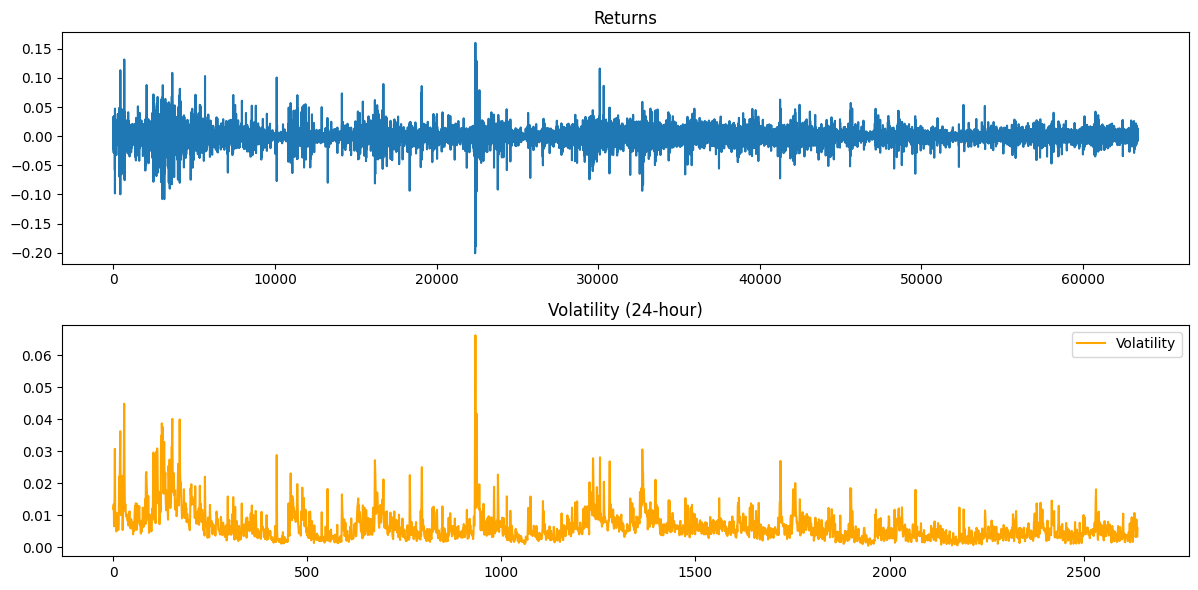

In [10]:
#W
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(returns, label="Returns")
plt.title("Returns")
plt.subplot(2, 1, 2)
plt.plot(vol, label="Volatility", color="orange")
plt.title("Volatility (24-hour)")
plt.legend()
plt.tight_layout()
plt.show()

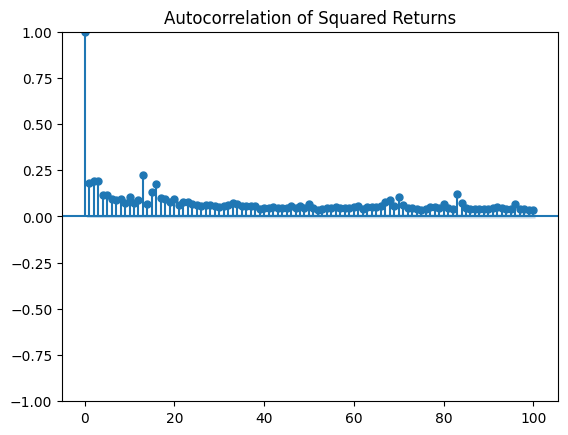

In [11]:
#Plot autocorrelation of squared returns (proxy for volatility)
plot_acf(np.square(returns), lags=100, title="Autocorrelation of Squared Returns")
plt.show()

In [12]:
#W
mean_vol = np.mean(vol)
std_vol = np.std(vol, ddof=1)
print(f"Mean Volatility: {mean_vol:.4f}")
print(f"Standard Deviation of Volatility: {std_vol:.4f}")


#Normality tests
shapiro_test = shapiro(vol)
dagostino_test = normaltest(vol)

print("Shapiro-Wilk Test:")
print(f"Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")
print("D’Agostino and Pearson’s Test:")
print(f"Statistic: {dagostino_test.statistic:.4f}, p-value: {dagostino_test.pvalue:.4f}")


Mean Volatility: 0.0066
Standard Deviation of Volatility: 0.0050
Shapiro-Wilk Test:
Statistic: 0.7553, p-value: 0.0000
D’Agostino and Pearson’s Test:
Statistic: 1848.1838, p-value: 0.0000


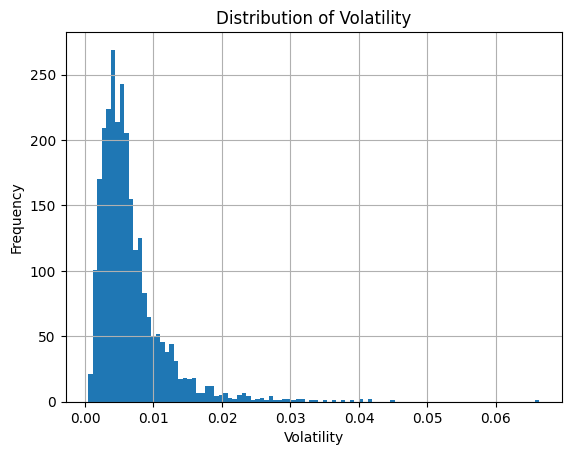

In [13]:
#W
plt.hist(vol, bins=100)
plt.title('Distribution of Volatility')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.grid()
plt.show()

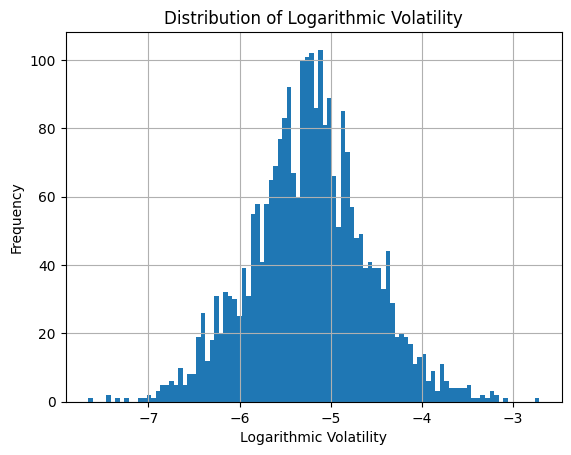

In [14]:
#W
log_vol = []

for volatility in vol:
    if volatility != 0:
        log_vol.append(np.log(volatility))
    else:
        log_vol.append(volatility)


plt.hist(log_vol, bins=100)
plt.title('Distribution of Logarithmic Volatility')
plt.xlabel('Logarithmic Volatility')
plt.ylabel('Frequency')
plt.grid()
plt.show()

<b>What are we working with?</b><br>

We have defined volatility as the standard deviation of returns over a given period of time, in this case, 24 hours. The first thing we observed when plotting both returns and volatility is that both seem to exhibit clustering. This was confirmed through the autocorrelation plot of squared returns, although it’s worth noting that this is just one measure; other metrics can be used, and autocorrelations can be analyzed similarly.

Next, we examined the mean and standard deviation of the volatility itself. Here, we observed that while the returns are already centered, the standard deviation of the volatility is significantly high compared to the mean. However, this mean is not excessively high when considering the market it pertains to, though it remains noteworthy.

Additionally, using the Shapiro-Wilk and D’Agostino tests, we confirmed that volatility does not follow a normal distribution. When plotting both the volatility and its logarithm, we found that the logarithm of volatility follows a log-normal distribution.

---

<b>The Butterfly Spread Strategy</b><br>
This strategy involves using three different strike prices: 
$K_1$, $K_2$ and $K_3$. Specifically:

Buy one call at strike price $K_1$: This gives you the right to buy the underlying asset at $K_1$<br>
Sell two calls at strike price $K_2$: You take on the obligation to sell the underlying asset at $K_2$, earning a premium for each call sold.<br>
Buy one call at strike price $K_3$: You purchase a right to buy the underlying asset at $K_3$, typically further out-of-the-money.<br>

The result is a payoff structure where you profit if the underlying asset's price ends up in the interval $[K_1;K_3]$, with the maximum profit occurring when the price is close to $K_2$.

<b>Mechanics of Options</b><br>

When you buy a call option, you pay a premium upfront. If the asset's price exceeds the strike price $K$ by more than the premium paid, you make a net profit. Otherwise, the option expires worthless, and your loss is limited to the premium.

When you sell a call option, you collect the premium upfront. If the asset’s price stays below the strike price $K$, the option expires worthless, and you keep the premium as profit. However, if the asset’s price rises above $K$, you are obligated to sell the asset at $K$, potentially incurring significant losses.

---

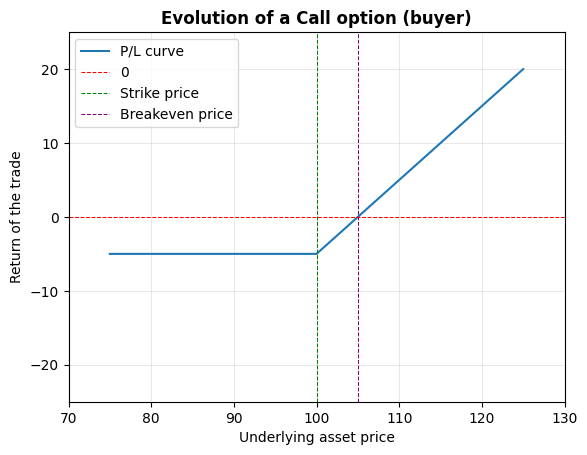

In [63]:
#E
Strike_price = 100
Asset_price = np.linspace(75, 125, 51)
Premium = 5

P_L = []

for i in Asset_price:
    if i < Strike_price:
        P_L.append(-Premium)
    else:
        Returns = i - Strike_price - Premium
        P_L.append(Returns)

plt.plot(Asset_price, P_L)
plt.title('Evolution of a Call option (buyer)', fontweight = 'bold')
plt.xlabel('Underlying asset price')
plt.ylabel('Return of the trade')
plt.ylim(-25,25)
plt.xlim(min(Asset_price) - 5, max(Asset_price) + 5)
plt.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.75)
plt.axvline(x = Strike_price, color = 'green', linestyle = '--', linewidth = 0.75)
plt.axvline(x = (Strike_price + Premium), color = 'purple', linestyle = '--', linewidth = 0.75)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5, alpha = 0.25)
plt.legend(['P/L curve', '0', 'Strike price', 'Breakeven price'])
plt.show()

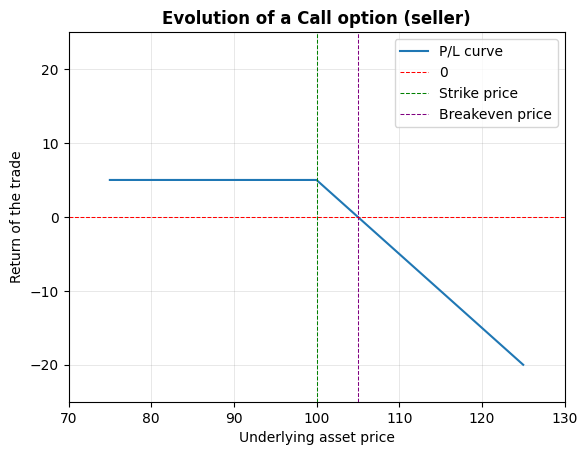

In [65]:
#E
Strike_price = 100
Asset_price = np.linspace(75, 125, 51)
Premium = 5

P_L = []

for i in Asset_price:
    if i < Strike_price:
        P_L.append(Premium)
    else:
        Returns = i - Strike_price - Premium
        P_L.append(-Returns)

plt.plot(Asset_price, P_L)
plt.title('Evolution of a Call option (seller)', fontweight = 'bold')
plt.xlabel('Underlying asset price')
plt.ylabel('Return of the trade')
plt.ylim(-25,25)
plt.xlim(min(Asset_price) - 5, max(Asset_price) + 5)
plt.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.75)
plt.axvline(x = Strike_price, color = 'green', linestyle = '--', linewidth = 0.75)
plt.axvline(x = (Strike_price + Premium), color = 'purple', linestyle = '--', linewidth = 0.75)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5, alpha = 0.25)
plt.legend(['P/L curve', '0', 'Strike price', 'Breakeven price'])
plt.show()

As we see, the positions of the buyer and the seller are exactly the opposite, now let's do the full butterfly spread

In [86]:
#E
# Strike prices and premiums
strike_1, premium_1 = 95, 10
strike_2, premium_2 = 100, 5
strike_3, premium_3 = 105, 2

# Asset prices
asset_price = np.linspace(85, 115, 51)

# Calculate butterfly spread P/L
call_return = []

for price in asset_price:
    if price < strike_1:  # Below the first strike
        single_return = -premium_1 + (2 * premium_2) - premium_3
    elif strike_1 <= price <= strike_2:  # Between strike_1 and strike_2
        single_return = (price - strike_1 - premium_1) + (2 * premium_2) - premium_3
    elif strike_2 < price < strike_3:  # Between strike_2 and strike_3
        single_return = (price - strike_1 - premium_1) + (2 * premium_2 - 2 * (price - strike_2)) - premium_3
    else:  # Above the third strike
        single_return = (price - strike_1 - premium_1) + (2 * premium_2 - 2 * (price - strike_2)) + (price - strike_3 - premium_3)
    call_return.append(single_return)

# Net cost of the butterfly spread
net_cost = premium_1 - 2 * premium_2 + premium_3

# Break-even points
breakeven_1 = strike_1 + net_cost
breakeven_2 = strike_3 - net_cost

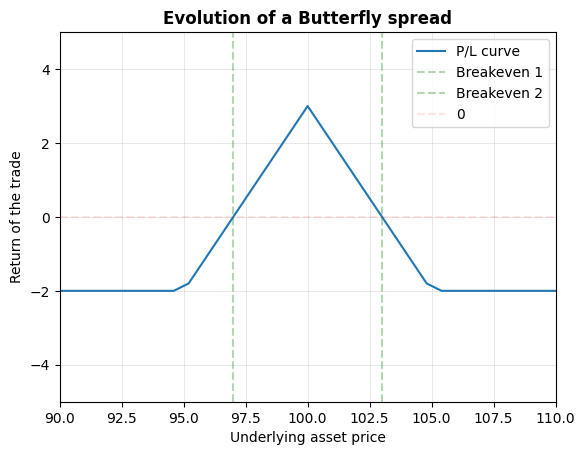

In [93]:
plt.plot(asset_price, call_return)
plt.title('Evolution of a Butterfly spread', fontweight = 'bold')
plt.xlabel('Underlying asset price')
plt.ylabel('Return of the trade')
plt.axvline(x = breakeven_1, color = 'green', alpha = 0.30, linestyle = '--')
plt.axvline(x = breakeven_2, color = 'green', alpha = 0.30, linestyle = '--')
plt.axhline(y = 0, color = 'red', alpha = 0.10, linestyle = '--')
plt.ylim(-5,5)
plt.xlim(90,110)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5, alpha = 0.25)
plt.legend(['P/L curve', 'Breakeven 1', 'Breakeven 2', '0'])
plt.show()